In [1]:
%load_ext autoreload

%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as likelihood_mr
#import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis
import CL_Mass_richness_relation as mr

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)


In [4]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [5]:
MR_modeling = mr.WL_Mass_Richness()
MR_modeling.set_pivot_values(analysis.z0, analysis.richness0)
profiles = data['stacked profile']
covariances = data['stacked covariance']

#modeling of the unitary excess surface density profile
def esd_modeling(R, log10m, c, z, cosmo, halo_profile = 'nfw'):
    return clmm.compute_excess_surface_density(R, 10**log10m, c, z, cosmo, delta_mdef=200,
                                       halo_profile_model=halo_profile, massdef='critical')

def esd_modeling_2h_nobias(R, z):
    moo = clmm.Modeling(massdef='critical', delta_mdef=200, halo_profile_model='nfw')
    moo.set_cosmo(cosmo)
    return moo.eval_excess_surface_density_2h(R, z, halobias=1)
#defining the likelihood
lnL = likelihood_mr.MR_from_Stacked_ESD_profiles(richness_individual = profiles['richness'], 
                                                   z_individual = profiles['redshift'], 
                                                   weights_per_bin_individual = profiles['W_l_true'],
                                                   covariance_stack = covariances['cov_t'], 
                                                   esd_stack = profiles['gt'],
                                                   radius_stack = profiles['radius'],
                                                   MRR_object = MR_modeling, esd_modeling = esd_modeling, cosmo = cosmo)

#reshape data 
lnL.reshape_data(r_min = 1, r_max = 5.5)
#lnL.reshape_data(r_min = 1, r_max = 15)
lnL.halo_regime(two_halo = False, esd_2h_nobias_modeling = esd_modeling_2h_nobias, c_m_relation = 'Duffy08')

In [6]:
lnL.compute_model(cosmo, 'nfw')

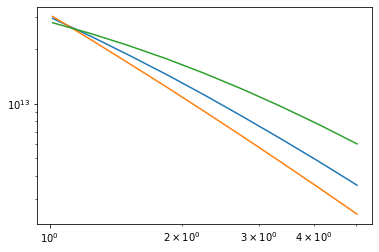

In [52]:
plt.plot(radius_th, [np.exp(lnL.interpolated_model['stack_0']['index_R_'+str(i)](14, 3)) for i in range(len(radius_th))])
plt.plot(radius_th, [np.exp(lnL.interpolated_model['stack_0']['index_R_'+str(i)](14, 10)) for i in range(len(radius_th))])
plt.loglog(radius_th, [np.exp(lnL.interpolated_model['stack_0']['index_R_'+str(i)](14, 1)) for i in range(len(radius_th))])

In [55]:
pwl = [14.14558953, -0.33464951,  0.72568023,  0.1877857 ]
lnL.lnLikelihood(pwl, which='full', scatter_lnc=.2, c_m_relation = 'Duffy08', two_halo_term = False, halo_profile='nfw', 
                 interpolation=True)
ds = lnL.ds
radius_th = lnL.radius

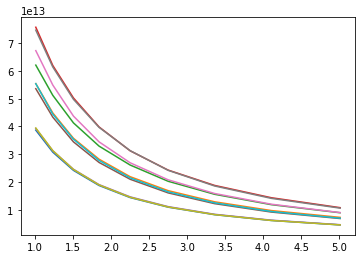

In [56]:
for i in range(10):
    plt.plot(radius_th, np.array(ds)[i, :])

In [ ]:
plt.imshow(lnL.tabulated_model['stack_0']['index_R_'+str(1)])

In [ ]:
radius_th = lnL.radius

In [ ]:
plt.plot(radius_th, [np.exp(lnL.interpolated_model['stack_0']['index_R_'+str(i)](14, 3)) for i in range(len(radius_th))])
plt.plot(radius_th, [np.exp(lnL.interpolated_model['stack_0']['index_R_'+str(i)](14, 10)) for i in range(len(radius_th))])
plt.loglog(radius_th, [np.exp(lnL.interpolated_model['stack_0']['index_R_'+str(i)](14, 1)) for i in range(len(radius_th))])
#plt.plot(radius_th, [np.exp(interpolated_model['stack_0']['index_R_'+str(i)](14, 2)) for i in range(len(radius_th))])